## Task
Analyse this CSV file and clean the data, visualize data, and do preprocessing for machine learning.

Here is all the data you need:
"/tmp/neuropsy_bp.csv"

## Plan
* **data_loading**: Load the data from "/tmp/neuropsy_bp.csv" into a pandas DataFrame.
* **data_exploration**: Explore the data to understand its structure, identify missing values, data types, and potential outliers.  Determine the shape of the data and the distribution of key variables.
* **data_cleaning**: Handle missing values (e.g., imputation or removal), address outliers, and correct inconsistencies in the data.  Ensure data types are appropriate for analysis and modeling.
* **data_wrangling**: Transform the data into a suitable format for machine learning. This may include encoding categorical variables, scaling numerical features, and creating new features if necessary.
* **data_visualization**: Create visualizations (histograms, box plots, scatter plots, etc.) to explore the relationships between variables and gain insights into the data. Visualize the distribution of key variables before and after cleaning.
* **feature_engineering**: Based on the data exploration and visualization, engineer new features that might improve model performance.  This could include interactions between existing variables, polynomial features, or other transformations.
* **data_splitting**: Split the cleaned and preprocessed data into training, validation, and testing sets.
* **data_preparation**: Finalize the data preparation steps, ensuring the data is ready for model training.
* **finish_task**: Summarize the data cleaning, preprocessing, and visualization steps performed. Include key insights from the data exploration and visualizations.  Mention the prepared datasets (train, validation, test) and their locations (if applicable).

In [32]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from typing import Tuple, Dict, Any, List

In [2]:
def clean(df: pd.DataFrame, impute: bool = False) -> pd.DataFrame:
    # Calculate the percentage of missing values in each column
    missing_percentage = df.isnull().sum() / len(df) * 100

    # Identify columns with more than 90% missing values
    columns_to_drop = missing_percentage[missing_percentage > 90].index

    # Drop the columns with more than 90% missing values
    df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

    if impute:
        # Impute missing numerical values with the median
        numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
        for col in numerical_cols:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

        # Impute missing categorical values with the mode
        categorical_cols = df_cleaned.select_dtypes(exclude=np.number).columns
        for col in categorical_cols:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

    return df_cleaned

In [3]:
def wrangle(df, impute: bool = False, cat_cardinality_threshold: int = 5):
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

    # Check cardinality for numerical columns, if < threshold, convert to categorical
    move_to_cat = []
    for col in numerical_cols:
        if df[col].nunique() < cat_cardinality_threshold:
            move_to_cat.append(col)
    for col in move_to_cat:
        numerical_cols.remove(col)
        categorical_cols.append(col)

    # Replace infinite values with NaN
    df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)

    if impute:
        # Impute NaN values in numerical columns with the median
        for col in numerical_cols:
            df[col] = df[col].fillna(df[col].median())

        # Impute NaN values in categorical columns with the mode
        for col in categorical_cols:
            if df[col].isnull().any():
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Apply Label Encoding to categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # Convert to string to handle NaN as a category
        df[col] = le.fit_transform(df[col])
    
    for col in numerical_cols:
        sc = StandardScaler()
        df[col] = sc.fit_transform(df[col].values.reshape(-1, 1))
    return df

In [ ]:
from __future__ import annotations

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from typing import Dict, Tuple, Any, Optional


class DataWrangler:
    """
    End-to-end dataframe pre-processor.

    Parameters
    ----------
    conversion_threshold : float, default 0.80
        Minimum share of non-null values that must convert to numeric
        before an object column is treated as numeric.
    cardinality_threshold : int, default 10
        Numeric columns with < threshold distinct values are treated
        as categoricals (avoids scaling one-hot-like/ordinal features).
    scale_numeric : bool, default True
        If True, apply `StandardScaler` to numeric columns.
    """

    def __init__(
        self,
        conversion_threshold: float = 0.80,
        cardinality_threshold: int = 10,
        scale_numeric: bool = True,
    ) -> None:
        self.conversion_threshold = conversion_threshold
        self.cardinality_threshold = cardinality_threshold
        self.scale_numeric = scale_numeric
        self.encoders: Dict[str, LabelEncoder] = {}
        self.scalers: Dict[str, StandardScaler] = {}
        self.nan_medians: Dict[str, float] = {}

    def _detect_and_cast(self, s: pd.Series) -> Tuple[pd.Series, bool]:
        s_clean = s.replace([np.inf, -np.inf], np.nan)
        if s_clean.dtype == "object":
            s_clean = s_clean.str.strip()

        coerced = pd.to_numeric(s_clean, errors="coerce")
        non_null, numeric_ok = s_clean.notna().sum(), coerced.notna().sum()

        if non_null and numeric_ok / non_null >= self.conversion_threshold:
            coerced = coerced.replace([np.inf, -np.inf], np.nan)
            return coerced, True
        return s_clean, False

    def wrangle(
        self, df: pd.DataFrame, *, fit: bool = True
    ) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Transform *df* in-place-safe manner and return
        (X_ready, params_dict) for downstream ML pipelines.

        Parameters
        ----------
        df   : input dataframe (left intact)
        fit  : if False, assumes encoders/scalers are already fitted;
               useful for transforming hold-out / test sets.

        Notes
        -----
        * Numeric NaNs ⇒ median per column.
        * Categorical NaNs ⇒ literal string ``"Missing"`` (is encoded).
        * Encoders & scalers stored so ``inverse_transform`` is trivial.
        """
        X = df.copy(deep=True)

        for col in X.columns:
            series, is_numeric = self._detect_and_cast(X[col])

            # (1) treat as *categorical* (either truly object or low-cardinality numeric)
            if (not is_numeric) or (
                is_numeric and series.nunique(dropna=True) < self.cardinality_threshold
            ):
                # fill NaNs before encoding
                series_filled = series.fillna("Missing").astype(str)

                if fit:
                    le = LabelEncoder()
                    X[col] = le.fit_transform(series_filled)
                    self.encoders[col] = le
                else:
                    le = self.encoders[col]
                    X[col] = le.transform(series_filled)

            # (2) treat as *numeric*
            else:
                series = series.replace([np.inf, -np.inf], np.nan)

                # median from finite numbers only
                if fit:
                    finite = series.dropna()
                    median = finite.median() if not finite.empty else 0.0
                    self.nan_medians[col] = median
                else:
                    median = self.nan_medians[col]

                series_filled = series.fillna(median).astype(float)

                if self.scale_numeric:
                    if fit:
                        scaler = StandardScaler()
                        # never passes NaN/Inf now
                        X[col] = scaler.fit_transform(series_filled.values.reshape(-1, 1)).ravel()
                        self.scalers[col] = scaler
                    else:
                        X[col] = self.scalers[col].transform(series_filled.values.reshape(-1, 1)).ravel()
                else:
                    X[col] = series_filled

        params: Dict[str, Any] = {
            "encoders": self.encoders,
            "scalers": self.scalers,
            "nan_medians": self.nan_medians,
            "scale_numeric": self.scale_numeric,
        }
        return X, params

    # ------------------------------------------------------------------ #
    # 3.  Inverse utilities (optional convenience)
    # ------------------------------------------------------------------ #
    def inverse_transform(
        self, X: pd.DataFrame, drop_scaled: bool = False
    ) -> pd.DataFrame:
        """
        Partially (or fully) reverse transformation.  Useful for:

        * inspection of feature importances on original scale
        * debugging / model explainability

        Parameters
        ----------
        drop_scaled : if True, scaled numerics are restored to original values;
                      otherwise, they stay standardised.
        """
        rev = X.copy(deep=True)

        # ▸ categorical
        for col, le in self.encoders.items():
            rev[col] = le.inverse_transform(rev[col].astype(int))

        # ▸ numeric
        if drop_scaled and self.scale_numeric:
            for col, scaler in self.scalers.items():
                col_arr = rev[col].values.reshape(-1, 1)
                rev[col] = scaler.inverse_transform(col_arr).ravel()

        # restore NaNs where appropriate
        for col, median in self.nan_medians.items():
            if pd.isna(median):
                continue
            rev.loc[rev[col] == median, col] = np.nan

        return rev


def wrangle(
    df: pd.DataFrame,
    *,
    conversion_threshold: float = 0.80,
    cardinality_threshold: int = 10,
    scale_numeric: bool = True,
) -> Tuple[pd.DataFrame, Dict[str, Any], DataWrangler]:
    """
    Stateless convenience wrapper; returns **(X_ready, params, fitted_wrangler)**.

    You can later reuse ``fitted_wrangler.wrangle(new_df, fit=False)`` on
    validation / test sets and call ``fitted_wrangler.inverse_transform``.

    >>> X_train_ready, params, wr = wrangle(train_df)
    >>> X_test_ready, _     = wr.wrangle(test_df, fit=False)
    """
    wr = DataWrangler(
        conversion_threshold=conversion_threshold,
        cardinality_threshold=cardinality_threshold,
        scale_numeric=scale_numeric,
    )
    X_ready, params = wr.wrangle(df, fit=True)
    return X_ready, params, wr


In [ ]:
try:
    raw_data = pd.read_csv('FACE/neuropsy_bp.csv', sep=';', low_memory=False)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df_cleaned = clean(raw_data)
df_cleaned.to_csv('FACE/neuropsy_bp_cleaned.csv', index=False)


df_wrangled, params, wr = wrangle(df_cleaned, conversion_threshold=0.80, cardinality_threshold=10, scale_numeric=True)
df_wrangled.to_csv('FACE/neuropsy_bp_wrangled.csv', index=False)

/opt/anaconda3/envs/chat-bot/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [27]:
N_RANDOM_SAMPLES = 20
CARDINALITY_THRESHOLD = 10      # below this distinct‐value count ⇒ “categorical”
CONVERSION_THRESHOLD = 0.95     # ≥95% of non‐null ⇒ we’ll coerce to numeric

def detect_and_cast(series: pd.Series):
    """
    Try to coerce object→numeric if most values convert cleanly.
    Returns (cleaned_series, is_numeric_bool).
    """
    s = series
    # strip whitespace on object strings
    if s.dtype == 'object':
        s = s.str.strip()

    # attempt numeric parse
    coerced = pd.to_numeric(s, errors='coerce')
    non_null = s.notna().sum()
    numeric_ok = coerced.notna().sum()

    # if enough values successfully parsed, treat as numeric
    if non_null > 0 and (numeric_ok / non_null) >= CONVERSION_THRESHOLD:
        return coerced, True
    else:
        return series, False


with open('neuropsy_bp_log.txt', 'w') as f:
    for col in df_cleaned.columns:
        original = df_cleaned[col]
        series, is_numeric = detect_and_cast(original)

        # override: if it really only has a handful of distinct values,
        # you might still want it “categorical”
        if is_numeric and series.nunique() < CARDINALITY_THRESHOLD:
            is_numeric = False

        # Log the column name, whether it is numeric and provide 10 random samples
        col_type = "Numeric" if is_numeric else "Categorical"
        samples = series.sample(n=min(N_RANDOM_SAMPLES, len(series)), random_state=0).tolist()

        f.write(f"{col} -- {col_type} -- Samples: {samples}\n")

In [ ]:
df_cleaned[col].iloc[np.random.choice(df_cleaned.index, 10, replace=False)]

4472   -0.67
5759     NaN
5752   -0.33
1727   -1.00
2908    0.00
4135   -1.00
550      NaN
1758    1.33
4077    0.67
3029    0.00
Name: mstcr_wais4, dtype: float64

In [9]:
categorical_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns.tolist()

In [10]:
categorical_cols

['cclin01_wais4',
 'cclin02_wais4',
 'cclin03_wais4',
 'cclin04_wais4',
 'cclin05_wais4',
 'cclin06_wais4',
 'cclin07_wais4',
 'cclin08_wais4',
 'cclin09_wais4',
 'cclin10_wais4',
 'cclin11_wais4',
 'cclin17_wais4',
 'trbapp01_wais4',
 'trbapp02_wais4',
 'trbapp03_wais4',
 'trbapp04_wais4',
 'trbapp05_wais4',
 'trbapp06_wais4',
 'trbapp07_wais4',
 'trbapp08_wais4',
 'trbapp09_wais4',
 'trbapp10_wais4',
 'vocabtot_wais4',
 'cvlt05z_wais4',
 'cvlt08z_wais4',
 'cvlt09z_wais4',
 'cvlt10z_wais4',
 'cvlt11z_wais4',
 'cvlt12_wais4',
 'cvlt12z_wais4',
 'cvlt13_wais4',
 'cvlt13z_wais4',
 'cvlt14z_wais4',
 'cvlt15z_wais4',
 'cvlt16_wais4',
 'cvlt16z_wais4',
 'cvlt17_wais4',
 'cvlt17z_wais4',
 'cvlt18_wais4',
 'cvlt18z_wais4',
 'cvlt19_wais4',
 'cvlt20_wais4',
 'cvlt20z_wais4',
 'cvlt21_wais4',
 'cvlt22_wais4',
 'code01_wais4',
 'symbol01_wais4',
 'ivt02_wais4',
 'ivt03_wais4',
 'wais4_mcod_4',
 'wais4_mcod_5',
 'wais4_mcod_6',
 'wais4_mcod_7',
 'wais4_mcod_8',
 'wais4_mcoi_3',
 'wais4_mcoi_4',
 

In [ ]:
df_cleaned['cclin01_wais4'].

0       32
1       33
2       25
3       59
4       35
        ..
6418    47
6419    72
6420    51
6421    35
6422    24
Name: cclin01_wais4, Length: 6423, dtype: object

In [ ]:
# Identify categorical and numerical columns
categorical_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

# Replace infinite values with NaN
df_cleaned[numerical_cols] = df_cleaned[numerical_cols].replace([np.inf, -np.inf], np.nan)

# Impute NaN values in numerical columns with the median
for col in numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df_cleaned)

# Convert sparse matrix to dense array
if hasattr(df_transformed, 'toarray'):
    df_transformed = df_transformed.toarray()

# Get feature names correctly
feature_names = list(numerical_cols)
categorical_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
feature_names.extend(categorical_feature_names)

# Create the DataFrame
df_wrangled = pd.DataFrame(df_transformed, columns=feature_names)
# df_wrangled.to_csv('FACE/neuropsy_bp_wrangled-OneHot.csv', index=False)


In [ ]:
# Identify categorical and numerical columns
categorical_cols = df_cleaned.select_dtypes(include=['object', 'bool']).columns
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

# Replace infinite values with NaN
df_cleaned[numerical_cols] = df_cleaned[numerical_cols].replace([np.inf, -np.inf], np.nan)

# Impute NaN values in numerical columns with the median
for col in numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Apply Label Encoding to categorical columns
# Create a copy to avoid SettingWithCopyWarning
df_encoded = df_cleaned.copy()
for col in categorical_cols:
    le = LabelEncoder()
    # Handle potential NaN values before encoding
    df_encoded[col] = df_encoded[col].astype(str) # Convert to string to handle NaN as a category
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Now apply StandardScaler to numerical columns
# Identify numerical columns again as LabelEncoding converts some to numerical types
numerical_cols_after_encoding = df_encoded.select_dtypes(include=['number']).columns

# Create transformers for numerical columns
numerical_transformer = StandardScaler()

# Combine transformers using ColumnTransformer
# Note: We only transform numerical columns now as categorical columns are already encoded
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_after_encoding)
    ],
    remainder='passthrough' # Keep the encoded categorical columns
)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df_encoded)

feature_names = preprocessor.get_feature_names_out()
df_wrangled = pd.DataFrame(df_transformed, columns=feature_names)

df_wrangled.to_csv('FACE/neuropsy_bp_wrangled-lEncoder.csv', index=False)

## Data visualization

### Subtask:
Visualize the data to explore relationships between variables and gain insights.


An AI generated notebook created with [Data Science Agent](https://labs.google.com/code/dsa) from Google Labs 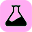
